# Hackerearth Predict The Churn Risk Rate Challenge
<hr>
<p align="center">
    <img src="https://d2908q01vomqb2.cloudfront.net/cb4e5208b4cd87268b208e49452ed6e89a68e0b8/2021/07/16/HackerEarthFeatureImage.png" width="500" height="600">
</p>

## Problem

Churn rate is a marketing metric that describes the number of customers who leave a business over a specific time period. . Every user is assigned a prediction value that estimates their state of churn at any given time. This value is based on:

* User demographic information
* Browsing behavior
* Historical purchase data among other information

It factors in our unique and proprietary predictions of how long a user will remain a customer. This score is updated every day for all users who have a minimum of one conversion. The values assigned are between 1 and 5.

## Task

Your task is to predict the churn score for a website based on the features provided in the dataset.

## Evaluation

<code> score = 100 x metrics.f1_score(actual, predicted, average="macro") </code>

Link : https://www.hackerearth.com/problem/machine-learning/predict-the-churn-risk-rate-11-fb7a760d/

## 1. Environment Setup

In [19]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# scikit-learn libraries/ML packages
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import f1_score
import lightgbm as lgb
import sklearn.utils as sku
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

## 2. Data Importing

In [20]:
# Import the training and testing dataset
df_train = pd.read_csv('data/train.csv', parse_dates=['joining_date'], na_values=['?','-999','Error','xxxxxxxx'])
df_test = pd.read_csv('data/test.csv', parse_dates=['joining_date'], na_values=['?','-999','Error','xxxxxxxx'])
sample = pd.read_csv('data/sample_submission.csv')

# Make a copy of the dataset
df_train_copy = df_train.copy()

## 3. Preprocessing

In [21]:
df_train_copy = df_train.copy()

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = KNNImputer(n_neighbors=2, weights="uniform")
enc = RobustScaler()
label_enc = LabelEncoder()
minmax_enc = MinMaxScaler()
def preprocess(data, train=True):
    '''
    Step 1: Feature Extraction
    Step 2: Dropping Columns
    Step 3: Filling Null Values
    Step 4: Converting to Categorica
    '''
    data['avg_frequency_login_days'] = pd.to_numeric(data['avg_frequency_login_days'], errors='coerce')
    
    # Step 1: Feature Extraction
    data['days_joined'] = data['joining_date'].apply(lambda x:(pd.Timestamp('today') - x).days)
    data['feedback'] = data['feedback'].apply(feedback_extract)
    
    # Step 2: Dropping the columns
    if(train==True):
        data = data[data['avg_time_spent'] > 0]
        data = data[data['points_in_wallet'] >= 0]
        data = data[data['churn_risk_score'] != -1]
        target = data['churn_risk_score']
        drop_cols = ['last_visit_time', 'joining_date', 'customer_id', 'Name', 'security_no', 'referral_id', 'churn_risk_score']
        data.drop(drop_cols, axis=1, inplace=True)
        
        
    elif(train==False):
        cust_id = data['customer_id']
        drop_cols = ['last_visit_time', 'joining_date', 'Name', 'security_no', 'referral_id', 'customer_id']
        data.drop(drop_cols, axis=1, inplace=True)
    
    # Step 4: Converting to categorical columns and adding cat codes
    for label, content in data.items():
        # Converting string dtypes to categorical columns
        if pd.api.types.is_string_dtype(content):
            data[label] = content.astype("category").cat.as_ordered()
        
        elif label in ['joining_quarter', 'joining_day', 'joining_year']:
            data[label] = content.astype("category").cat.as_ordered()
    
    # Step 3: Filling Null Values
    mode_cols = ['region_category', 'joined_through_referral', 'preferred_offer_types', 'medium_of_operation']
    data[mode_cols] = imp.fit_transform(data[mode_cols])
        
    median_col = ['points_in_wallet', 'avg_frequency_login_days', 'days_since_last_login']
    data[median_col] = imputer.fit_transform(data[median_col])
    
    numerical = []
    labels = []
    
    for label, content in data.items():
        if not pd.api.types.is_string_dtype(content):
            numerical.append(label)
        else:
            labels.append(label)
            
    data[numerical] = enc.fit_transform(data[numerical])
    
    for lab in labels:
        data[lab] = label_enc.fit_transform(data[lab])

    if train == True:
        return data, target
    elif train == False:
        return data, cust_id

def feedback_extract(data):
    good_feed = ['Products always in Stock', 'Quality Customer Care', 'User Friendly Website', 'Reasonable Price']
    bad_feed = ['Poor Website', 'Poor Product Quality', 'Poor Customer Service', 'Too many ads']
    if data in good_feed:
        return 'Positive'
    elif data in bad_feed:
        return 'Negative'
    else:
        return 'None'

In [22]:
df_train_copy, target = preprocess(df_train_copy)

In [23]:
df_train_copy.isnull().sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
days_joined                     0
dtype: int64

In [24]:
len(target)

30855

In [25]:
df_train_copy.isnull().sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
days_joined                     0
dtype: int64

## 4. Model Experimentation

In [26]:
def model_experimentation(models, X_train, X_test, y_train, y_test):
    '''
    Fit and Score the deep learning models without performing hyperparameter tuning
    '''
    model_scores = {}
    model_item = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_preds= model.predict(X_test)
        model_scores[name] = 100 * f1_score(y_test, model_preds, average='macro')
        model_item[name] = model
    return model_scores, model_item

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv, n_jobs=-1, error_score='raise')
	return scores

def test_prediction(model, X, name='submission.csv'):
    predicted_df = pd.DataFrame()
    X, predicted_df['customer_id'] = preprocess(X, False)
    predicted_df['churn_risk_score'] = model.predict(X)
    predicted_df.to_csv('data/'+name)

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

In [34]:
df_test = pd.read_csv('data/test.csv', parse_dates=['joining_date'], na_values=['?','-999','Error','xxxxxxxx'])
model_GBR = lgb.LGBMClassifier(objective='multi', random_state=42, n_jobs=-1)
model_GBR.fit(df_train_copy, target)
test_prediction(model_GBR, df_test)

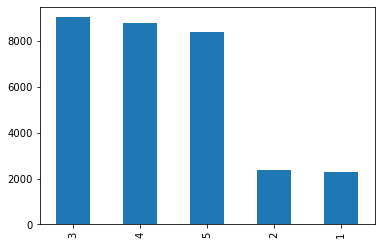

In [41]:
target.value_counts().plot(kind='bar')

In [51]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
n_HP_points_to_test = 100
clf = lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1, n_estimators=5000, objective='multi')
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=n_HP_points_to_test,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True, n_jobs=-1)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_train_copy, target, test_size=0.33, random_state=42)

In [53]:
gs.fit(X_train, y_train)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 28.9min finished


Best score reached: 0.7940209764361037 with params: {'colsample_bytree': 0.6399212548086342, 'min_child_samples': 303, 'min_child_weight': 10.0, 'num_leaves': 10, 'reg_alpha': 10, 'reg_lambda': 50, 'subsample': 0.6346234410851537} 


In [54]:
df_test = pd.read_csv('data/test.csv', parse_dates=['joining_date'], na_values=['?','-999','Error','xxxxxxxx'])
model_GBR =  lgb.LGBMClassifier(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1, n_estimators=5000, objective='multi',
                               colsample_bytree=0.6399212548086342, min_child_samples=303, min_child_weight=10,
                               num_leaves=10, reg_alpha=10, reg_lambda=50, subsample=0.6346234410851537)
model_GBR.fit(df_train_copy, target)
test_prediction(model_GBR, df_test)